## Package Import

In [1]:
!pip install optuna


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.pandas.set_option('display.max_columns', None) 
sns.set_theme(color_codes = True)

import os
import sys
import tqdm
import random
import warnings
warnings.filterwarnings('ignore')

# ELO
from ELO import ELO

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss

# pytorch
import torch
print(torch.cuda.is_available())

# Wandb
import wandb
from wandb.xgboost import WandbCallback
wandb.login(key = '') # Personal Key 입력

# XGBoost
from xgboost import XGBClassifier
from xgboost import plot_importance as xgb_plot_importance

# Optuna
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from optuna.integration import XGBoostPruningCallback

# Seed 고정
SEED = 42
def seed_everything(seed) :
    random.seed(seed)
    np.random.seed(seed)
    # tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
    torch.use_deterministic_algorithms(True)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
seed_everything(SEED)

True


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ksj006151. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /opt/ml/.netrc


## Load Preprocessed Data

In [37]:
# data = pd.read_parquet('./data/data_preprocessed.parquet')
data = pd.read_parquet('/data/ephemeral/level2-dkt-recsys-05/data/New_Feature_Selection.parquet')
data


,userID,assessmentItemID,answerCode,KnowledgeTag,testID,testCode,testNum,problemID,problemID_Norm,year,month,day,hour,dow,weekday,ElapsedTime,ElapsedTime_Rolling2,ElapsedTime_Rolling3,ElapsedTime_Rolling4,ElapsedTime_Rolling5,user_ElaspedTime_avg,item_ElaspedTime_avg,testID_ElaspedTime_avg,testCode_ElaspedTime_avg,testNum_ElaspedTime_avg,problemID_ElaspedTime_avg,tag_ElaspedTime_avg,Real_Solved,Correct_User_ElapsedTime,Wrong_User_ElapsedTime,user_sum,user_cnt,user_acc,user_itemID_sum,user_itemID_cnt,user_itemID_acc,user_testID_sum,user_testID_cnt,user_testID_acc,user_testCode_sum,user_testCode_cnt,user_testCode_acc,user_testNum_sum,user_testNum_cnt,user_testNum_acc,user_problemID_sum,user_problemID_cnt,user_problemID_acc,user_tag_sum,user_tag_cnt,user_tag_acc,itemID_sum,itemID_cnt,itemID_acc,testID_sum,testID_cnt,testID_acc,testCode_sum,testCode_cnt,testCode_acc,testNum_sum,testNum_cnt,testNum_acc,problemID_sum,problemID_cnt,problemID_acc,tag_sum,tag_cnt,tag_acc,itemID_high_freq,testID_high_freq,testCode_high_freq,testNum_high_freq,problemID_high_freq,tag_high_freq,user_past_solved,relative_correct_rate,is_correct_before1,correct_rate_before1,relative_correct_rate_before1,is_correct_before2,correct_rate_before2,relative_correct_rate_before2,is_correct_before3,correct_rate_before3,relative_correct_rate_before3,is_correct_before4,correct_rate_before4,relative_correct_rate_before4,is_correct_before5,correct_rate_before5,relative_correct_rate_before5,theta,beta,quarter,total_problem
0,0,A060001001,1,0,7224,6,1,1,0.000000,2020,3,24,0,1,1,0.0,0.0,0.000000,0.00,0.0,38.262057,0.079794,18.804632,66.971222,37.934893,3.989678,13.583961,0,0.081091,0.000000,0,0,0.000000,0,0,0.0,0,0,0.00,0,0,0.00,0,0,0.00,0,0,0.0,0,0,0.00,246,250,0.984000,1429,1500,0.952667,210971,296350,0.711898,11867,16750,0.708478,310634,414350,0.749690,718,750,0.957333,0,0,1,1,1,0,0,0.016000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.0,1.0,0.578202,-3.342176,1,7
1,0,A060001002,1,0,7225,6,1,2,0.083333,2020,3,24,0,1,1,3.0,1.5,0.000000,0.00,0.0,38.262057,13.660000,18.804632,66.971222,37.934893,73.232491,28.919573,0,11.363636,83.125000,1,1,1.000000,0,0,0.0,1,1,1.00,1,1,1.00,1,1,1.00,0,0,0.0,0,0,0.00,242,250,0.968000,1429,1500,0.952667,210971,296350,0.711898,11867,16750,0.708478,297842,413500,0.720295,3439,3750,0.917067,0,0,1,1,1,1,0,0.032000,1,0.984000,0.016000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.0,1.0,0.578202,-3.003042,1,7
2,0,A060001003,1,0,7225,6,1,3,0.166667,2020,3,24,0,1,1,8.0,5.5,3.666667,0.00,0.0,38.262057,26.112000,18.804632,66.971222,37.934893,73.933021,28.919573,0,24.637555,42.190476,2,2,1.000000,0,0,0.0,2,2,1.00,2,2,1.00,2,2,1.00,0,0,0.0,1,1,1.00,229,250,0.916000,1429,1500,0.952667,210971,296350,0.711898,11867,16750,0.708478,285143,414250,0.688336,3439,3750,0.917067,0,0,1,1,1,1,0,0.084000,1,0.968000,0.032000,1,0.984000,0.016000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.0,1.0,0.578202,-2.298332,1,7
3,0,A060001004,1,0,7225,6,1,4,0.250000,2020,3,24,0,1,1,7.0,7.5,6.000000,4.50,0.0,38.262057,19.180000,18.804632,66.971222,37.934893,70.596414,28.919573,0,19.572016,5.571429,3,3,1.000000,0,0,0.0,3,3,1.00,3,3,1.00,3,3,1.00,0,0,0.0,2,2,1.00,243,250,0.972000,1429,1500,0.952667,210971,296350,0.711898,11867,16750,0.708478,273382,412050,0.663468,3439,3750,0.917067,0,0,1,1,1,1,0,0.028000,1,0.916000,0.084000,1,0.968000,0.032000,1,0.984000,0.016000,1,1.000000,1.000000,1,1.0,1.0,0.578202,-3.064188,1,7
4,0,A060001005,1,0,7225,6,1,5,0.333333,2020,3,24,0,1,1,7.0,7.0,7.333333,6.25,5.0,38.262057,18.076000,18.804632,66.971222,37.934893,69.928460,28.919573,0,18.569620,9.076923,4,4,1.000000,0,0,0.0,4,4,1.00,4,4,1.00,4,4,1.00,0,0,0.0,3,3,1.00,237,250,0.948000,1429,1500,0.952667,210971,296350,0.711898,11867,16750,0.708478,240452,401900,0.598288,3439,3750,0.917067,0,0,1,1,1,1,0,0.052000,1,0.972000,0.028000,1,0.916000,0.084000,1,0.968000,0.032000,1,0.984000,0.016000,1,1.0,1.0,0.578202,-2.647697,1,7
...,...,...,...,...,...,

In [39]:
data_dtype = data.dtypes.to_frame().T
data_isnull = data.isnull().sum().to_frame().T
print(f'Row 개수 : {data.shape[0]} / Columns 개수 : {data.shape[1]}')

data_info = pd.concat([data_dtype, data_isnull], axis = 0).set_index(pd.Index(['Dtype', 'Null']))
data_info

Row 개수 : 2526700 / Columns 개수 : 116


,userID,assessmentItemID,answerCode,KnowledgeTag,testID,testCode,testNum,problemID,problemID_Norm,year,month,day,hour,dow,weekday,ElapsedTime,ElapsedTime_Rolling2,ElapsedTime_Rolling3,ElapsedTime_Rolling4,ElapsedTime_Rolling5,user_ElaspedTime_avg,item_ElaspedTime_avg,testID_ElaspedTime_avg,testCode_ElaspedTime_avg,testNum_ElaspedTime_avg,problemID_ElaspedTime_avg,tag_ElaspedTime_avg,Real_Solved,Correct_User_ElapsedTime,Wrong_User_ElapsedTime,user_sum,user_cnt,user_acc,user_itemID_sum,user_itemID_cnt,user_itemID_acc,user_testID_sum,user_testID_cnt,user_testID_acc,user_testCode_sum,user_testCode_cnt,user_testCode_acc,user_testNum_sum,user_testNum_cnt,user_testNum_acc,user_problemID_sum,user_problemID_cnt,user_problemID_acc,user_tag_sum,user_tag_cnt,user_tag_acc,itemID_sum,itemID_cnt,itemID_acc,testID_sum,testID_cnt,testID_acc,testCode_sum,testCode_cnt,testCode_acc,testNum_sum,testNum_cnt,testNum_acc,problemID_sum,problemID_cnt,problemID_acc,tag_sum,tag_cnt,tag_acc,itemID_high_freq,testID_high_freq,testCode_high_freq,testNum_high_freq,problemID_high_freq,tag_high_freq,user_past_solved,relative_correct_rate,is_correct_before1,correct_rate_before1,relative_correct_rate_before1,is_correct_before2,correct_rate_before2,relative_correct_rate_before2,is_correct_before3,correct_rate_before3,relative_correct_rate_before3,is_correct_before4,correct_rate_before4,relative_correct_rate_before4,is_correct_before5,correct_rate_before5,relative_correct_rate_before5,theta,beta,quarter,total_problem,ElapsedTime_std,ElapsedTime_Rolling2_std,ElapsedTime_Rolling3_std,ElapsedTime_Rolling4_std,ElapsedTime_Rolling5_std,user_ElaspedTime_avg_std,item_ElaspedTime_avg_std,testID_ElaspedTime_avg_std,testCode_ElaspedTime_avg_std,testNum_ElaspedTime_avg_std,problemID_ElaspedTime_avg_std,tag_ElaspedTime_avg_std,Correct_User_ElapsedTime_std,Wrong_User_ElapsedTime_std,itemID_acc_std,testID_acc_std,testCode_acc_std,testNum_acc_std,problemID_acc_std,tag_acc_std
Dtype,int16,object,int8,int16,int16,int8,int16,int8,float64,int16,int8,int8,int8,int8,int8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int8,float64,float64,int16,int16,float64,int16,int16,float64,int16,int16,float64,int16,int16,float64,int16,int16,float64,int16,int16,float64,int16,int16,float64,int64,int64,float64,int64,int64,float64,int64,int64,float64,int64,int64,float64,int64,int64,float64,int64,int64,float64,int8,int8,int8,int8,int8,int8,int8,float64,int8,float64,float64,int8,float64,float64,int8,float64,float64,int8,float64,float64,int8,float64,float64,float64,float64,int64,int8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [205]:
use_col = [
    'userID', 'assessmentItemID', 'KnowledgeTag', 'testID',
    'testCode', 'testNum', 'problemID', # 'problemID_Norm'
    
    'year', 'month', 'day', 'hour', 'dow', 'weekday', 'ElapsedTime',
    'ElapsedTime_Rolling2', 'ElapsedTime_Rolling3', 'ElapsedTime_Rolling4', 'ElapsedTime_Rolling5',
    'user_ElaspedTime_avg', 'item_ElaspedTime_avg', 'testID_ElaspedTime_avg', 'testCode_ElaspedTime_avg',
    'testNum_ElaspedTime_avg', 'problemID_ElaspedTime_avg', 'tag_ElaspedTime_avg',
    'Real_Solved', 'Correct_User_ElapsedTime', 'Wrong_User_ElapsedTime',
    
    'user_sum', 'user_cnt', 'user_acc', 'user_itemID_sum', 'user_itemID_cnt', 'user_itemID_acc',
    'user_testID_sum', 'user_testID_cnt', 'user_testID_acc', 'user_testCode_sum', 'user_testCode_cnt', 'user_testCode_acc',
    'user_testNum_sum', 'user_testNum_cnt', 'user_testNum_acc', 'user_problemID_sum', 'user_problemID_cnt', 'user_problemID_acc',
    'user_tag_sum', 'user_tag_cnt', 'user_tag_acc',
    
    'itemID_sum', 'itemID_cnt', 'itemID_acc', 'testID_sum', 'testID_cnt', 'testID_acc',
    'testCode_sum', 'testCode_cnt', 'testCode_acc', 'testNum_sum', 'testNum_cnt', 'testNum_acc',
    'problemID_sum', 'problemID_cnt', 'problemID_acc', 'tag_sum', 'tag_cnt', 'tag_acc',
    'itemID_high_freq', 'testID_high_freq', 'testCode_high_freq',
    'testNum_high_freq', 'problemID_high_freq', 'tag_high_freq',

    'user_past_solved',
    # 'relative_correct_rate',
    'is_correct_before1', 'correct_rate_before1', 'relative_correct_rate_before1',
    'is_correct_before2', 'correct_rate_before2', 'relative_correct_rate_before2',
    'is_correct_before3', 'correct_rate_before3', 'relative_correct_rate_before3',
    'is_correct_before4', 'correct_rate_before4', 'relative_correct_rate_before4',
    'is_correct_before5', 'correct_rate_before5', 'relative_correct_rate_before5',
    
    'theta', 'beta', 'quarter', 'total_problem'
]
print(len(use_col))

63


## Data Split

In [62]:
train_le, test_le = data[data['answerCode'] != -1], data[data['answerCode'] == -1].drop(columns = 'answerCode')
valid_indices = set(data[data['answerCode'] != -1].index).intersection(set(data.reset_index().groupby('userID', as_index = False).last().set_index('index').index))

obj_col = ['assessmentItemID', 'testID']
for col in obj_col :
    le = LabelEncoder()
    train_le[col] = le.fit_transform(train_le[col])
    for label in tqdm.tqdm((test_le[col].unique())) : 
        if label not in le.classes_ : 
            le.classes_ = np.append(le.classes_, label)
    test_le[col] = le.transform(test_le[col])

train_GB = train_le.loc[~train_le.index.isin(valid_indices)]
valid_GB = train_le.loc[train_le.index.isin(valid_indices)]
print(train_GB.shape, valid_GB.shape)

X_train, y_train = train_GB[use_col], train_GB['answerCode']
X_valid, y_valid = valid_GB[use_col], valid_GB['answerCode']
test_GB = test_le[use_col]

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, test_GB.shape)

100%|██████████| 273/273 [00:00<00:00, 118817.58it/s]


(2519258, 116) (6698, 116)
(2519258, 112) (2519258,) (6698, 112) (6698,) (744, 112)


In [63]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(0.8)
train_thresh = selector.fit(X_train)

In [64]:
select_feat = train_thresh.get_feature_names_out()
print(select_feat)
print(len(select_feat))

['userID' 'assessmentItemID' 'KnowledgeTag' 'testID' 'testCode' 'testNum'
 'problemID' 'month' 'day' 'hour' 'dow' 'ElapsedTime'
 'ElapsedTime_Rolling2' 'ElapsedTime_Rolling3' 'ElapsedTime_Rolling4'
 'ElapsedTime_Rolling5' 'user_ElaspedTime_avg' 'item_ElaspedTime_avg'
 'testID_ElaspedTime_avg' 'testCode_ElaspedTime_avg'
 'testNum_ElaspedTime_avg' 'problemID_ElaspedTime_avg'
 'tag_ElaspedTime_avg' 'Correct_User_ElapsedTime' 'Wrong_User_ElapsedTime'
 'user_sum' 'user_cnt' 'user_testID_sum' 'user_testID_cnt'
 'user_testCode_sum' 'user_testCode_cnt' 'user_testNum_sum'
 'user_testNum_cnt' 'user_problemID_sum' 'user_problemID_cnt'
 'user_tag_sum' 'user_tag_cnt' 'itemID_sum' 'itemID_cnt' 'testID_sum'
 'testID_cnt' 'testCode_sum' 'testCode_cnt' 'testNum_sum' 'testNum_cnt'
 'problemID_sum' 'problemID_cnt' 'tag_sum' 'tag_cnt' 'beta' 'quarter'
 'total_problem' 'ElapsedTime_std' 'ElapsedTime_Rolling2_std'
 'ElapsedTime_Rolling3_std' 'ElapsedTime_Rolling4_std'
 'ElapsedTime_Rolling5_std' 'user_Elasp

In [56]:
X_train = X_train[select_feat]
X_valid = X_valid[select_feat]
test_GB = test_GB[select_feat]
X_train.shape, X_valid.shape, test_GB.shape

((2519258, 67), (6698, 67), (744, 67))

## XGBoostClassifier

### Optuna HPO

In [181]:
def objective_XGB_CLF(trial : Trial, X_train, y_train, X_valid, y_valid) :
    param = {
        'booster' : trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'max_depth' : trial.suggest_int('max_depth', 1, 15),
        'learning_rate' : trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1, 0.5]),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 10),
        'gamma' : trial.suggest_categorical('alpha', [1e-5, 1e-3, 1, 5, 10]),
        'colsample_bytree' : trial.suggest_categorical('colsample_bytree', [0.1, 0.5, 1]),
        'lambda' : trial.suggest_categorical('lambda', [1e-5, 1e-3, 1, 5, 10]),
        'alpha' : trial.suggest_categorical('alpha', [1e-5, 1e-3, 1, 5, 10]),
        'subsample' : trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 1.0]),
        'max_delta_step' : trial.suggest_categorical('max_delta_step', [0.1, 0.5, 1, 5, 10]),
    }
    pruning_callback = XGBoostPruningCallback(trial, 'validation_1-' + 'auc')
    model = XGBClassifier(**param, n_estimators = 3000, objective = 'binary:logistic', eval_metric = 'auc',
                          nthread = -1, tree_method = 'hist', device = 'cuda', updater = 'grow_gpu_hist',
                          callbacks = [pruning_callback], # predictor = 'gpu_predictor', 
                          early_stopping_rounds = 100, random_state = SEED)
    xgb_model = model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)], verbose = 300)
    
    proba = xgb_model.predict_proba(X_valid)
    # score = log_loss(y_valid, proba[:, 1])
    # score = accuracy_score(y_valid, np.where(proba[:, 1] >= 0.5, 1, 0))
    score = roc_auc_score(y_valid, proba[:, 1])
    return score

In [ ]:
# Study Optuna
study = optuna.create_study(direction = 'maximize', sampler = TPESampler(seed = SEED))
study.optimize(lambda trial : objective_XGB_CLF(trial, X_train, y_train, X_valid, y_valid), show_progress_bar = True, n_trials = 100)
print(f'Best trial : score {study.best_trial.value}, \n params = {study.best_trial.params} \n')

- Best trial : score 0.8381156953162443 
    - params = {'booster': 'gbtree', 'max_depth': 5, 'learning_rate': 0.5, 'min_child_weight': 8, 'alpha': 1, 'colsample_bytree': 0.1, 'lambda': 0.001, 'subsample': 0.8, 'max_delta_step': 0.1}

- Best trial : score 0.8672109047626494, 
    - params = {'booster': 'dart', 'max_depth': 11, 'learning_rate': 0.5, 'min_child_weight': 8, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 5, 'subsample': 1.0, 'max_delta_step': 10} 

### Train

[0]	validation_0-auc:0.80250	validation_1-auc:0.77870
[100]	validation_0-auc:0.87923	validation_1-auc:0.83856
[200]	validation_0-auc:0.89746	validation_1-auc:0.84171
[300]	validation_0-auc:0.90866	validation_1-auc:0.84250
[400]	validation_0-auc:0.91742	validation_1-auc:0.84352
[500]	validation_0-auc:0.92437	validation_1-auc:0.84354
[546]	validation_0-auc:0.92728	validation_1-auc:0.84348
ROC-AUC Score : 0.8438 / Accuracy : 0.7619 / Logloss : 0.4865


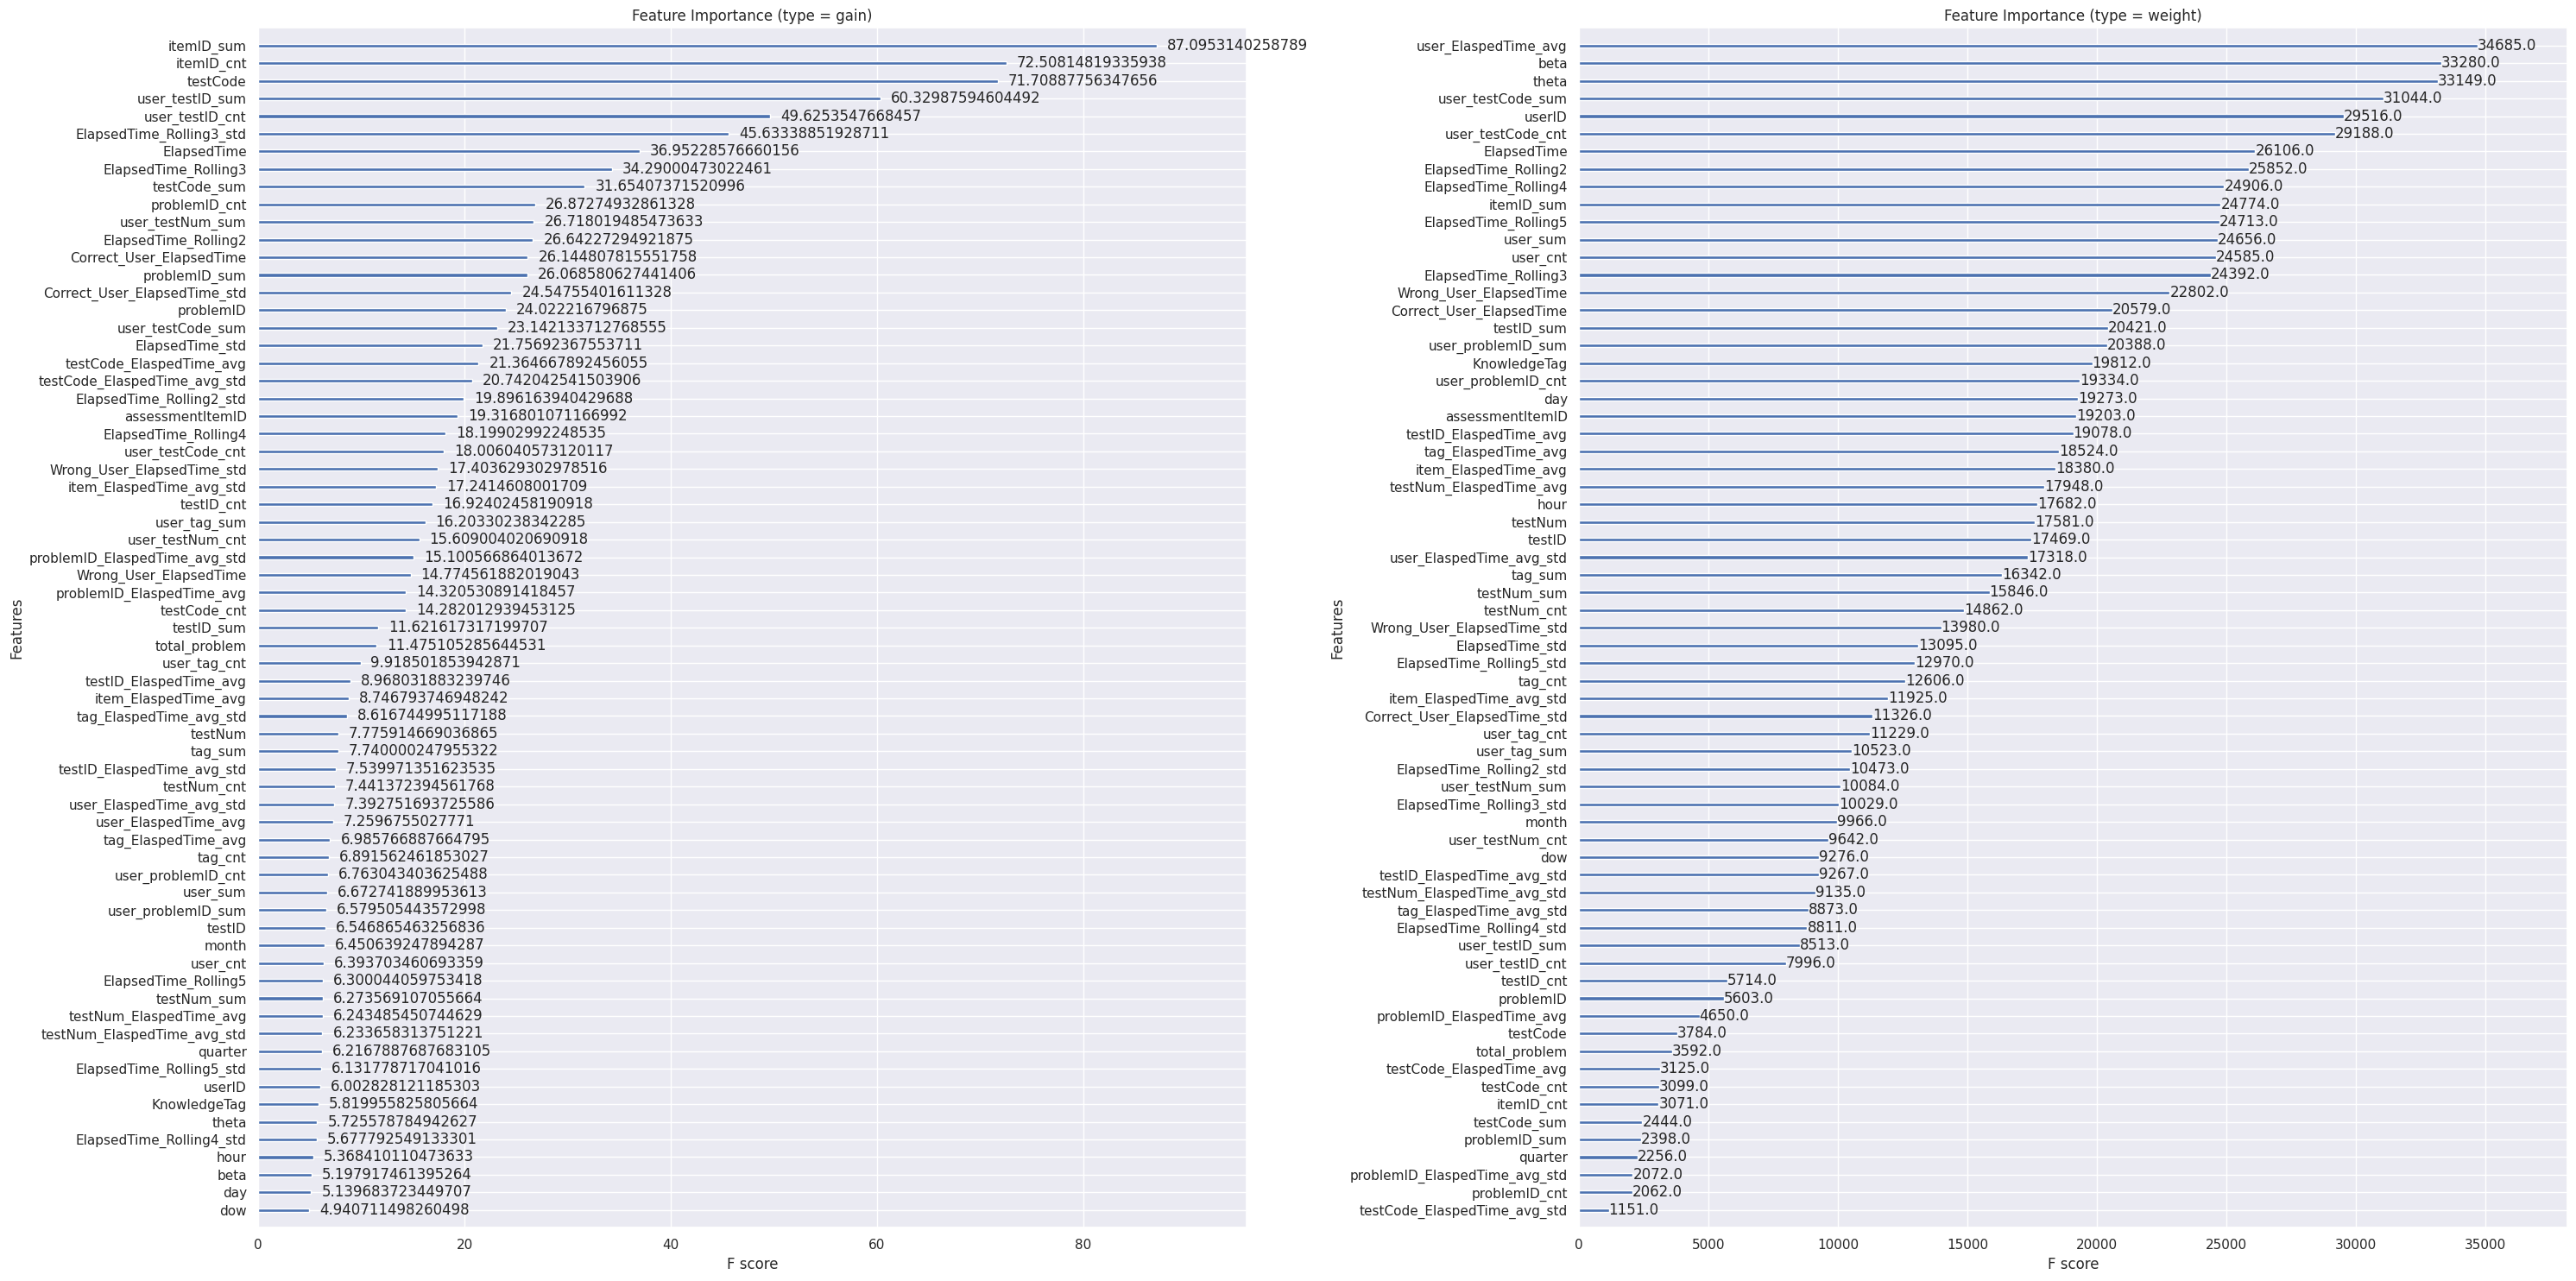

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


best_iteration,▁
best_score,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_0-auc,▁▁▂▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████
validation_1-auc,▁▂▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████████████
best_iteration,447
best_score,0.84381
epoch,546


In [57]:
# param = study.best_params
param = {'booster': 'gbtree', 'max_depth': 12, 'learning_rate': 0.05, 'min_child_weight': 3, 'alpha': 1, 'colsample_bytree': 0.5, 'lambda': 0.001, 'subsample': 1.0, 'max_delta_step': 5}

wandb.init(project = 'dkt-jsj')
wandb.run.name = 'XGBoost_0121_var08_add_pro_total'
wandb.run.save()

xgb_clf = XGBClassifier(**param, n_estimators = 3000, objective = 'binary:logistic', eval_metric = 'auc',
                        nthread = -1, device = 'cuda', tree_method = 'gpu_hist', predictor = 'gpu_predictor', 
                        early_stopping_rounds = 100, random_state = SEED)
xgb_clf.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)], verbose = 100,
            callbacks = [WandbCallback(log_model = True, log_feature_importance = True, importance_type = 'weight')])

# 모델 지표 출력
proba = xgb_clf.predict_proba(X_valid)
roc_auc = roc_auc_score(y_valid, proba[:, 1])
accuracy = accuracy_score(y_valid, np.where(proba[:, 1] >= 0.5, 1, 0))
logloss = log_loss(y_valid, proba[:, 1])
print(f'ROC-AUC Score : {roc_auc:.4f} / Accuracy : {accuracy:.4f} / Logloss : {logloss:.4f}')

# Feature Importance 출력
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30, 15))
xgb_plot_importance(xgb_clf, ax = axes[0], importance_type = 'gain')
axes[0].set_title('Feature Importance (type = gain)')
xgb_plot_importance(xgb_clf, ax = axes[1], importance_type = 'weight')
axes[1].set_title('Feature Importance (type = weight)')
plt.tight_layout() ; plt.show()
wandb.finish()

In [58]:
# xgb_clf.save_model('./model/XGB_Feature91.model')
xgb_clf.save_model('./model/XGBoost_0121_var08_add_pro_total.model')

383 / 744
0.0006593472 0.9943587


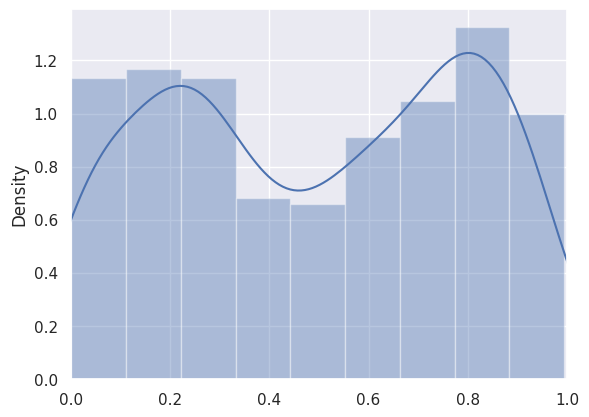

In [59]:
# xgb_clf.load_model('./model/XGB_Feature91.model')
pred = xgb_clf.predict(test_GB)
proba = xgb_clf.predict_proba(test_GB)[:, 1]
print(f'{sum(pred)} / {len(pred)}') ; print(min(proba), max(proba))
sns.distplot(proba) ; plt.xlim([0, 1]) ; plt.show()

In [60]:
# SAVE OUTPUT
output_dir = 'submit/'
write_path = os.path.join(output_dir, 'XGBoost_0121_var08_add_pro_total.csv')
if not os.path.exists(output_dir) :
    os.makedirs(output_dir)
with open(write_path, 'w', encoding = 'utf8') as w :
    print('Writing Prediction : {}'.format(write_path))
    w.write('id,prediction\n')
    for id, p in enumerate(proba) :
        w.write('{},{}\n'.format(id, p))

Writing Prediction : submit/XGBoost_0124_var07_feat67_add_std.csv
